  KAGGLE AUTHENTICATION THROUGH UPLOADING API FILE

In [0]:
import zipfile
from google.colab import auth
auth.authenticate_user()

In [0]:
import os
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ferdi33","key":"98cb2f31922e43ead612a3740a2b75f7"}'}

In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

kaggle.json


In [0]:
!ls -l ~/.kaggle
!cat ~/.kaggle/kaggle.json

total 4
-rw------- 1 root root 63 May  7 07:16 kaggle.json
{"username":"ferdi33","key":"98cb2f31922e43ead612a3740a2b75f7"}

In [0]:
!pip install -q kaggle
!pip install -q kaggle-cli

     |████████████████████████████████| 81kB 3.2MB/s 
     |████████████████████████████████| 5.3MB 8.1MB/s 
     |████████████████████████████████| 102kB 33.3MB/s 
     |████████████████████████████████| 51kB 23.1MB/s 


DOWNLOADING AND UNZIPPING FILES

In [0]:
!kaggle competitions download -c histopathologic-cancer-detection

  0% 0.00/1.33M [00:00<?, ?B/s]
100% 1.33M/1.33M [00:00<00:00, 89.9MB/s]
  0% 0.00/5.10M [00:00<?, ?B/s]
100% 5.10M/5.10M [00:00<00:00, 80.8MB/s]
100% 1.30G/1.30G [00:09<00:00, 209MB/s]
100% 1.30G/1.30G [00:09<00:00, 143MB/s]
100% 4.97G/4.98G [00:40<00:00, 86.8MB/s]
100% 4.98G/4.98G [00:40<00:00, 131MB/s] 


In [0]:

zipf = zipfile.ZipFile('../content/train.zip')
zipf.extractall('../content/train')

In [0]:
zipf = zipfile.ZipFile('../content/test.zip')
zipf.extractall('../content/test/test')

In [0]:
! rm -r ../content/train_labels.csv
zipf = zipfile.ZipFile('../content/train_labels.csv.zip')
zipf.extractall()

In [0]:
# Añadir la extensión .tiff en el csv con los labels, para que el flow_from_dataframe pueda leer las imagenes.
import pandas as pd
df = pd.read_csv('../content/train_labels.csv')

df['label'] = df['label'].astype(str)
df['id'] = df['id'].apply(lambda x: x+'.tif')

df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835.tif,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif,1
2,755db6279dae599ebb4d39a9123cce439965282d.tif,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif,0
4,068aba587a4950175d04c680d38943fd488d6a9d.tif,0


In [0]:
# Split en validation/train
from sklearn.model_selection import train_test_split

train_df, valid_df = train_test_split(df, test_size=0.2)

In [0]:
import keras
from keras_preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [0]:
datagen=ImageDataGenerator(rescale=1./255,
                          rotation_range=45,
                          horizontal_flip=True,
                          vertical_flip=True,
                          )

train_generator=datagen.flow_from_dataframe(dataframe=train_df, 
                                            directory="../content/train", 
                                            x_col="id", y_col="label", 
                                            class_mode="categorical", 
                                            target_size=(32,32), 
                                            batch_size=256)

validation_generator=datagen.flow_from_dataframe(dataframe=valid_df, 
                                                 directory="../content/train", 
                                                 x_col="id", y_col="label", 
                                                 class_mode="categorical", 
                                                 target_size=(32,32), 
                                                 batch_size=256)

Found 176020 images belonging to 2 classes.
Found 44005 images belonging to 2 classes.


MODELO NN

In [0]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(12, activation='relu'))
model.add(layers.Dense(2, activation='softmax'))

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 32)          9248      
_________________________________________________________________
flatten_1 (Flatten)  

In [0]:
n_epochs = 5
batch_size=64

model.fit_generator(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = validation_generator, 
    validation_steps = validation_generator.samples // batch_size,
    epochs = n_epochs)

Instructions for updating:
Use tf.cast instead.
Epoch 1/5
2750/2750 [==============================] - 1861s 677ms/step - loss: 0.4778 - acc: 0.7742 - val_loss: 0.4140 - val_acc: 0.8173
Epoch 2/5
2750/2750 [==============================] - 1598s 581ms/step - loss: 0.4173 - acc: 0.8094 - val_loss: 0.4188 - val_acc: 0.8032
Epoch 3/5
2750/2750 [==============================] - 1557s 566ms/step - loss: 0.3911 - acc: 0.8240 - val_loss: 0.3749 - val_acc: 0.8320
Epoch 4/5
2750/2750 [==============================] - 1553s 565ms/step - loss: 0.3745 - acc: 0.8337 - val_loss: 0.3833 - val_acc: 0.8381
Epoch 5/5
2750/2750 [==============================] - 1554s 565ms/step - loss: 0.3633 - acc: 0.8400 - val_loss: 0.3706 - val_acc: 0.8352


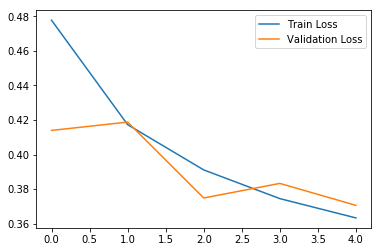

In [0]:
import matplotlib.pyplot as plt
plt.plot(model.history.history['loss'], label='Train Loss')
plt.plot(model.history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

Generate the predictions to upload to kaggle ** TODO**





In [0]:
test_dir = '../content/test/test'
test_datagen = ImageDataGenerator(rescale=1./255)


print(os.getcwd()+os.path.sep+test_dir)
test_generator = test_datagen.flow_from_directory(
        '../content/test',
        target_size=(32, 32),
        color_mode="rgb",
        batch_size=2,
        shuffle=False)
filenames = test_generator.filenames
nb_samples = len(filenames)

/content/../content/test/test
Found 57458 images belonging to 1 classes.


In [0]:
predictions = model.predict_generator(test_generator,steps = nb_samples//2)

In [49]:
predictions[:10]

['0', '0', '0', '0', '0', '0', '1', '0', '0', '0']

In [0]:
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())

In [0]:
predictions = [labels[k] for k in predicted_class_indices]

In [54]:
print(predictions)

['0', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '1', '0', '1', '0', '1', '0', '0', '0', '0', '0', '1', '1', '0', '0', '0', '0', '0', '1', '1', '0', '0', '0', '0', '0', '0', '0', '1', '1', '0', '0', '1', '0', '0', '0', '0', '0', '1', '0', '1', '1', '0', '0', '0', '0', '0', '0', '1', '0', '0', '1', '1', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '1', '1', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '1', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '1', '0', '0', '0', '0', '0', '0',

In [70]:
filenames=test_generator.filenames
print(filenames[:10])

['test/00006537328c33e284c973d7b39d340809f7271b.tif', 'test/0000ec92553fda4ce39889f9226ace43cae3364e.tif', 'test/00024a6dee61f12f7856b0fc6be20bc7a48ba3d2.tif', 'test/000253dfaa0be9d0d100283b22284ab2f6b643f6.tif', 'test/000270442cc15af719583a8172c87cd2bd9c7746.tif', 'test/000309e669fa3b18fb0ed6a253a2850cce751a95.tif', 'test/000360e0d8358db520b5c7564ac70c5706a0beb0.tif', 'test/00040095a4a671280aeb66cb0c9231e6216633b5.tif', 'test/000698b7df308d75ec9559ef473a588c513a68aa.tif', 'test/0006e1af5670323331d09880924381d67d79eda0.tif']


In [71]:
# Remove .tiff extension and /test at the beginning
filenames = [x[:-4] for x in filenames]
filenames = [x[5:] for x in filenames]
print(filenames[:5])

['00006537328c33e284c973d7b39d340809f7271b', '0000ec92553fda4ce39889f9226ace43cae3364e', '00024a6dee61f12f7856b0fc6be20bc7a48ba3d2', '000253dfaa0be9d0d100283b22284ab2f6b643f6', '000270442cc15af719583a8172c87cd2bd9c7746']


In [0]:
results=pd.DataFrame({"id":filenames,
                      "label":predictions})
results.to_csv("results.csv",index=False)

In [66]:
print(filenames3[:10])

['00006537328c33e284c973d7b39d340809f7271b', '0000ec92553fda4ce39889f9226ace43cae3364e', '00024a6dee61f12f7856b0fc6be20bc7a48ba3d2', '000253dfaa0be9d0d100283b22284ab2f6b643f6', '000270442cc15af719583a8172c87cd2bd9c7746', '000309e669fa3b18fb0ed6a253a2850cce751a95', '000360e0d8358db520b5c7564ac70c5706a0beb0', '00040095a4a671280aeb66cb0c9231e6216633b5', '000698b7df308d75ec9559ef473a588c513a68aa', '0006e1af5670323331d09880924381d67d79eda0']


In [84]:
import kaggle
!kaggle competitions submissions -c histopathologic-cancer-detection -f "../content/results.csv" -m "Automatic Submission"

usage: kaggle [-h] [-v] {competitions,c,datasets,d,kernels,k,config} ...
kaggle: error: unrecognized arguments: -f -m Automatic Submission


In [80]:
os.getcwd()


'/content'